## What Types of Treatment Outcomes Contribute to Patient Perceived Overall Satisfaction and Improvement in Psychiatry


Heavily influenced by the medical model, we tend to conceptulize patient improvements as <i> symptom reduction </i>. 

The less symptoms a person has, the happier they should be. 

However, there are certainly many different aspects to patient perceived satisfaction and improvements. 

For some patients, although they still experience some psychiatric symptoms after treratment, say depressive mood, they are able to cope with it and pursue a life worth living. 
For some patients, even when they do not experience clinical level psychiatric symptoms, they may not be able to bring their functioning back to where they hope it to be. 

Thus, we tried to understand which types of treatment outcomes (i.e., symptom reduction, coping abilities, positive mental health, functioning, and well-being) are more critical for patient perceved overall satisfaction and improvement after completing a partial hospital program.  

###  Load Packages

In [464]:
import glob
import pandas as pd
import re
import numpy as np
from plotnine import *
import warnings
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore') 
#Just to make the notebook clearer. You should not run this line when you were testing your code. 

### Load Data 
Read in treatment outcome data assessed by RDQ and patients overall ratings after treatment. 
Note that for confidentiatliy, we cannot release raw data to anyone outside of the hospital. 

In [465]:
#RDQ: Different Types of Treatment Outcomes
rdqPre = pd.read_spss('../Data/PrePostMeasures/RDQPre_1.sav') #Pre-treatment
rdqPost = pd.read_spss('../Data/PrePostMeasures/RDQPost_1.sav') #Post-treatment

#Discharge Package: Patient perceived satisfaction & Improvement 
satOld = pd.read_spss('../Data/PHPSatisfaction/EndofTreatmentSurveyData/EOT Verfication_1.sav')#Old data before 2020
satNew = pd.read_spss('../Data/DischargePacket/2022-06-06 dc.sav') #New data after 2020
#We swtiched the platform for data collection in 2020 so we have two separate datasets

#Diagnosis
dx = pd.read_spss('../Data/DemosDx/Diagnosis_1.sav') 

#Demographics
demo = pd.read_spss('../Data/DemosDx/Demographics Form_1.sav')

### Data Pre-processing
Make sure all variables types are correct and create aggregated vraibles from the items.

In [466]:
#Change ID type from float to object
rdqPre.ID1 = rdqPre.ID1.astype('object') 
rdqPost.ID1 = rdqPost.ID1.astype('object') 

#Replace text with level orders 
rdqPre = rdqPre.replace(
    {'not at all or rarely true': 0, 'sometimes true': 1, 'often or almost always true': 2})
rdqPost = rdqPost.replace(
    {'not at all or rarely true': 0, 'sometimes true': 1, 'often or almost always true': 2})

#Convert reverse items in RDQ
for i in [29,30,48,49,50,51,52] :
    colname1 = 'rdqpre_' + str(i) + '_1'
    colname2 = 'rdqpost_' + str(i) + '_1'
    rdqPre[colname1] = abs(rdqPre[colname1].astype('float') - 2)
    rdqPost[colname2] = abs(rdqPost[colname2].astype('float') - 2)

In [467]:
#Agregate items in each RDQ section
rdqPre['pre_sym'] = rdqPre.iloc[:,1:26].mean(axis = 1) #Pre-treatment Symptom Reduction
rdqPre['pre_cope'] = rdqPre.iloc[:,26:31].mean(axis = 1) #Pre-treatment Coping
rdqPre['pre_pmh'] = rdqPre.iloc[:,31:43].mean(axis = 1) #Pre-treatment Positive Mental Health
rdqPre['pre_fun'] = rdqPre.iloc[:,43:53].mean(axis = 1) #Pre-treatment Functioning
rdqPre['pre_well'] = rdqPre.iloc[:,53:61].mean(axis = 1) #Pre-treatment Well-being

rdqPost['post_sym'] = rdqPost.iloc[:,1:26].mean(axis = 1) #Post-treatment Symptom Reduction
rdqPost['post_cope'] = rdqPost.iloc[:,26:31].mean(axis = 1)#Post-treatment Coping
rdqPost['post_pmh'] = rdqPost.iloc[:,31:43].mean(axis = 1) #Post-treatment Positive Mental Health
rdqPost['post_fun'] = rdqPost.iloc[:,43:53].mean(axis = 1) #Post-treatment Functioning
rdqPost['post_well'] = rdqPost.iloc[:,53:61].mean(axis = 1)#Post-treatment Well-being

rdq = pd.merge(rdqPre, rdqPost, on = 'ID1', how = 'inner') 
#Merge pre- and post-treatment RDQ data 
#how = 'inner': Only retain people who have both pre- and post-treatment data

In [468]:

#Rename variables to ensure consistency between the old and new datasets

satGlobalOld = satOld.loc[:,['PHP_ID_1','OVERALL_1', 'IMPRV_1']].rename(columns = {'PHP_ID_1': 'ID1', 'OVERALL_1': 'overall1',
                                                                                   'IMPRV_1': 'imprv1'})
satGlobalNew = satNew.loc[:,['id1','overall_1', 'imprv_1']].rename(columns = {'id1': 'ID1', 'overall_1': 'overall1',
                                                                              'imprv_1': 'imprv1'})


Note that this is a example of bad data maintenance. 
Should always keep corresponding variable names across old and new datasets conssitent.   

In [469]:
#Merge old and new discharge package (i.e., overall satisfaction/improvement) datasets
satGlobal = pd.concat([satGlobalOld, satGlobalNew],axis = 0) #Use concact to merge data by columns
satGlobal = satGlobal[satGlobal.ID1 != 0] #Remove invalid IDs
satGlobal.ID1 = satGlobal.ID1.astype('object') #Change ID type from float to object

Let's see what we get here.

In [470]:
print('N of people who were administered with the discharge package:', satGlobal.shape[0]) 
print('Overall Satisfaction Missing Values = ', sum(satGlobal.overall1.isnull()),'\n'
      'Overall Improvement Missing Values = ', sum(satGlobal.imprv1.isnull()))

N of people who were administered with the discharge package: 3811
Overall Satisfaction Missing Values =  49 
Overall Improvement Missing Values =  46


In [471]:
#Merge RDQ and discharge packages, diagnoses, and demographics
df = pd.merge(satGlobal, rdq, how = 'inner', on = 'ID1') #Only include people who have data on both RDQ and at discharge
df = pd.merge(df, dx, how = 'left', on = 'ID1') #Adding diagnoses to included people 
df = pd.merge(df, demo, how = 'left', on = 'ID1') #Adding demographic info to included people 

In [472]:
#Exclude people who had more than 10 missing values in pre- and post-treatment RDQ - deemed unreliable
df = df[df.filter(regex='rdqpre').isnull().sum(axis=1) <=10] 
df = df[df.filter(regex='rdqpost').isnull().sum(axis=1) <=10] 
print('People who completed the program and have less than 10 missing values in RDQ at intake and discharge', 
      df.shape[0])
df.to_csv('../Data/df_satisfaction_rdq_dx_demo.csv', encoding='utf-8', index=False) #Save data for later use

People who completed the program and have less than 10 missing values in RDQ at intake and discharge 2711


### Data Formating

Now we need to do some more advanced data preping to make visualization easier. 
If you are a ggplot2/plotnine user, you will favor long over wide data. 

In [473]:
#Use melt to create long data

df_long_pre = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')
        #Merge RDQ scores of different subscales into one column named rdqvalue
        #Label subscale name in another column named rdqvar 
        
df_long_pre = \
pd.melt(df_long_pre, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')
        #Merge patient perceived overall satisfaction and improvement into one collumn named satvalue
        #Label them accordingly in another column named satvalue

df_long_pre.rdqvar = df_long_pre.rdqvar.astype('category').cat.reorder_categories(
    ['pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well']) 
df_long_pre.satvar = df_long_pre.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])
#Make thse label columns as categorical variables


#Repeat the same process but use it on post-treatment data
df_long_post = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')
df_long_post = \
pd.melt(df_long_post, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long_post.rdqvar = df_long_post.rdqvar.astype('category').cat.reorder_categories(
    ['post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well'])
df_long_post.satvar = df_long_post.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])


#Compute Change Score (larger values = larger improvement)
df['change_sym'] = df.pre_sym - df.post_sym 
df['change_cope'] = df.post_cope - df.pre_cope
df['change_pmh'] = df.post_pmh - df.pre_pmh
df['change_fun'] = df.post_fun - df.pre_fun
df['change_well'] = df.post_well - df.pre_well

#Repeat the same process for change scores
df_long_change = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')

df_long_change = \
pd.melt(df_long_change, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long_change.rdqvar = df_long_change.rdqvar.astype('category').cat.reorder_categories(
    ['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well'])
df_long_change.satvar = df_long_change.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])

### Pairewise Correlations 

Before we move on to visualization. Let's quickly view variable relationships through pairwise correlations. 

In [474]:
df[['overall1', 'imprv1', 'pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well']].corr()

,overall1,imprv1,pre_sym,pre_cope,pre_pmh,pre_fun,pre_well
overall1,1.000000,0.557869,-0.021413,0.025154,0.030022,0.023102,0.041632
imprv1,0.557869,1.000000,-0.097867,0.095942,0.158059,0.129033,0.135814
pre_sym,-0.021413,-0.097867,1.000000,-0.484959,-0.535086,-0.560089,-0.494452
pre_cope,0.025154,0.095942,-0.484959,1.000000,0.547704,0.496269,0.499837
pre_pmh,0.030022,0.158059,-0.535086,0.547704,1.000000,0.584589,0.756277
pre_fun,0.023102,0.129033,-0.560089,0.496269,0.584589,1.000000,0.600678
pre_well,0.041632,0.135814,-0.494452,0.499837,0.756277,0.600678,1.000000


Good to know that the patients' overall satisfaction (overall1) was related to their perceived improvements (impv1) at the end of treatment, and these two end-of-treament variables were not related to their pre-treatment symptom, coping, positve mental health, functioning, well-being much (r < 0.2). 

The RDQ components had moderate to high correlations. Note that by design the direction of the symptom variable was the opposite to the other variables. 


Let's move on to post-treatment RDQ. 

In [475]:
df[['overall1', 'imprv1', 'post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well']].corr() 

,overall1,imprv1,post_sym,post_cope,post_pmh,post_fun,post_well
overall1,1.000000,0.557869,-0.232156,0.222340,0.277009,0.228834,0.262392
imprv1,0.557869,1.000000,-0.457884,0.469925,0.552663,0.445714,0.532114
post_sym,-0.232156,-0.457884,1.000000,-0.687098,-0.687886,-0.686617,-0.675026
post_cope,0.222340,0.469925,-0.687098,1.000000,0.700477,0.697753,0.700857
post_pmh,0.277009,0.552663,-0.687886,0.700477,1.000000,0.716889,0.866689
post_fun,0.228834,0.445714,-0.686617,0.697753,0.716889,1.000000,0.763448
post_well,0.262392,0.532114,-0.675026,0.700857,0.866689,0.763448,1.000000


We can tell that the RDQ treatment outcome scores were more relavent to patient perceived improvement than patient satisfaction. It's probably because most people who could stay until the end were generally satisfied with the program (We'll see if it's true when visualizing the data, or you can simply do a count table to see how people rate the program in general.) 

Postive mental health has the strongest relationship with patient perceived improvement. The second strong one was well-being, the third coping abilities, the fourth symptom reduction, the fifth functioning. Surprised?

Let's also take a look at the average change scores. 

In [476]:
#Means of change scores
df[['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well']].mean(axis = 0)

change_sym     0.527292
change_cope    0.500564
change_pmh     0.552289
change_fun     0.432705
change_well    0.585467
dtype: float64

And take a look at correlations between patient satisfaction/improvement and change scores.

In [477]:
df[['overall1', 'imprv1', 'change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well']].corr()

,overall1,imprv1,change_sym,change_cope,change_pmh,change_fun,change_well
overall1,1.000000,0.557869,0.218829,0.176180,0.243768,0.193641,0.216945
imprv1,0.557869,1.000000,0.383187,0.335784,0.407886,0.307530,0.401322
change_sym,0.218829,0.383187,1.000000,0.529319,0.635684,0.572509,0.585998
change_cope,0.176180,0.335784,0.529319,1.000000,0.576605,0.539565,0.568636
change_pmh,0.243768,0.407886,0.635684,0.576605,1.000000,0.621767,0.763486
change_fun,0.193641,0.307530,0.572509,0.539565,0.621767,1.000000,0.655897
change_well,0.216945,0.401322,0.585998,0.568636,0.763486,0.655897,1.000000


Similarly, among RDQ facets, positive mental health has the strongest relationship with patient perceived improvement. The second one was well-being, the thrid symptom reduction, thr fourth coping abilities, and the fifth functioning.

Interestingly, if you compare the results with the table above, you'll find that patient perceived improvement had stronger relationships with <i> raw </i> post-treatment RDQ scores than <i> changes </i> of RDQ scores.  

### Visualization

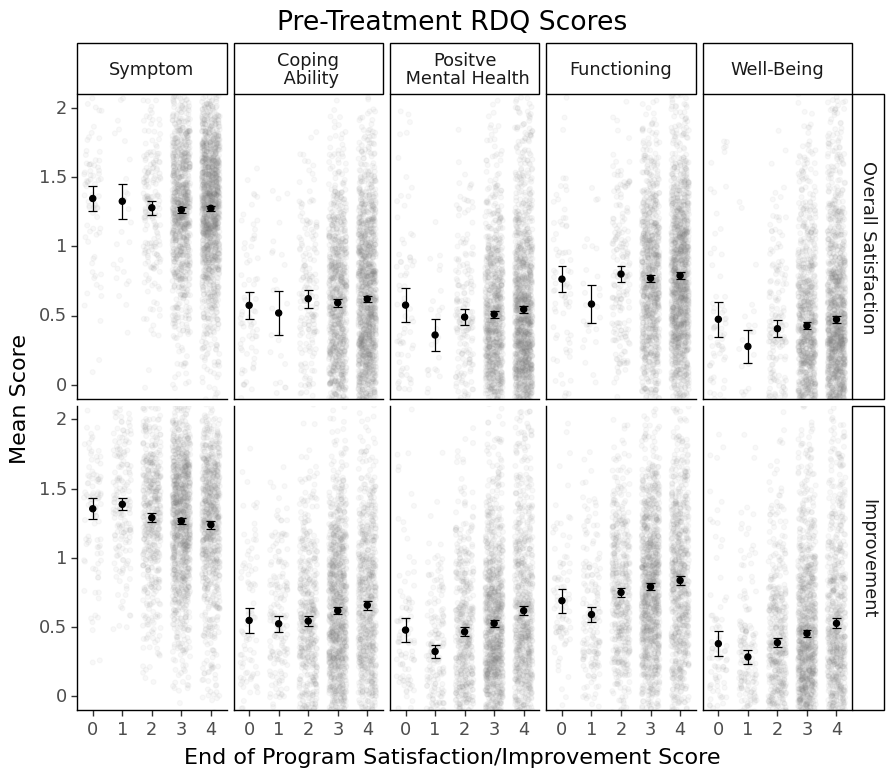

<ggplot: (8789393619574)>

In [478]:
#Rename labels
def facet_label(s):
    if 'sym' in s: return('Symptom')
    if 'cope' in s: return ('Coping\n Ability')
    if 'pmh' in s: return('Positve\n Mental Health')
    if 'fun' in s: return ('Functioning')
    if 'well' in s: return('Well-Being')
    if 'overall' in s: return('Overall Satisfaction')
    if 'imprv' in s: return('Improvement')
    
#Pre-treatment RDQ Scores and Post-treatment Patient Perceived Satisfaction & Improvement
ggplot(df_long0, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     coord_cartesian(ylim = (0,2)) + \
     xlab('End of Program Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Pre-Treatment RDQ Scores')


X-axis is the end of program patient perceived satisfaciton/improvement score. The grey dots in the background indicate actual data points. The black dots indicate the mean scores. The error bars indicate 95% CIs. Based on the error bars, you can get a sense of whether there is a significant difference or not.  

Remember I said that most people who stayed in the program till the end probably had fairly high satisfaction? You can tell from the first row of the figure, most people rated a 3 or 4 for satisfaction (more grey dots there). 

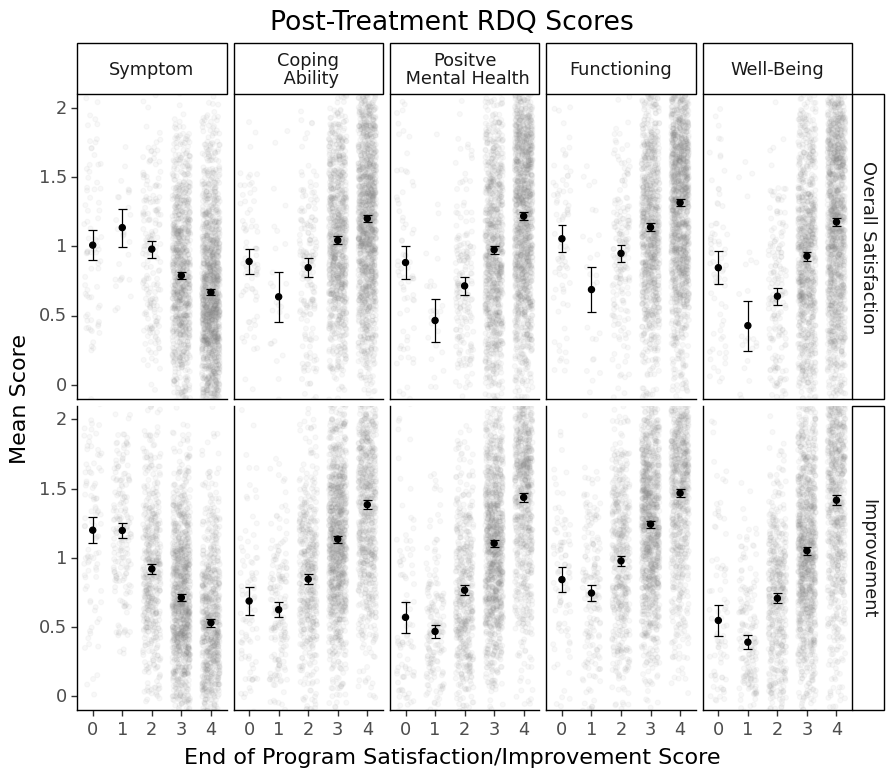

<ggplot: (8789394117907)>

In [479]:
#Post-treatment RDQ Scores and Post-treatment Patient Perceived Satisfaction & Improvement
ggplot(df_long, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     coord_cartesian(ylim = (0,2)) + \
     xlab('End of Program Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Post-Treatment RDQ Scores')

See that <i> almost </i> linear relationships between RDQ facets and Satisfaction/Improvement?

You can tell that people who gave 0s to satisfaction and improvement at the end of treatment tended to perform differently from the linear trend and had a larger within-group heterogeneity. 
I wonder why these people were able to stick to the end of the partial program (a very intense type of program) when they were completely unsatisfied and/or saw no improvement. 

For a research project, we usually stop here. But if I were the program director, I would also check the overall response tendency of these people who gave 0s to satisfaction/improvement to other questionnaires (if they took questionnaires seriously, if their answeres were consistent and reliable, their other characteristics, etc.) Unsatisfied customers can sometimes tell us more, right? 


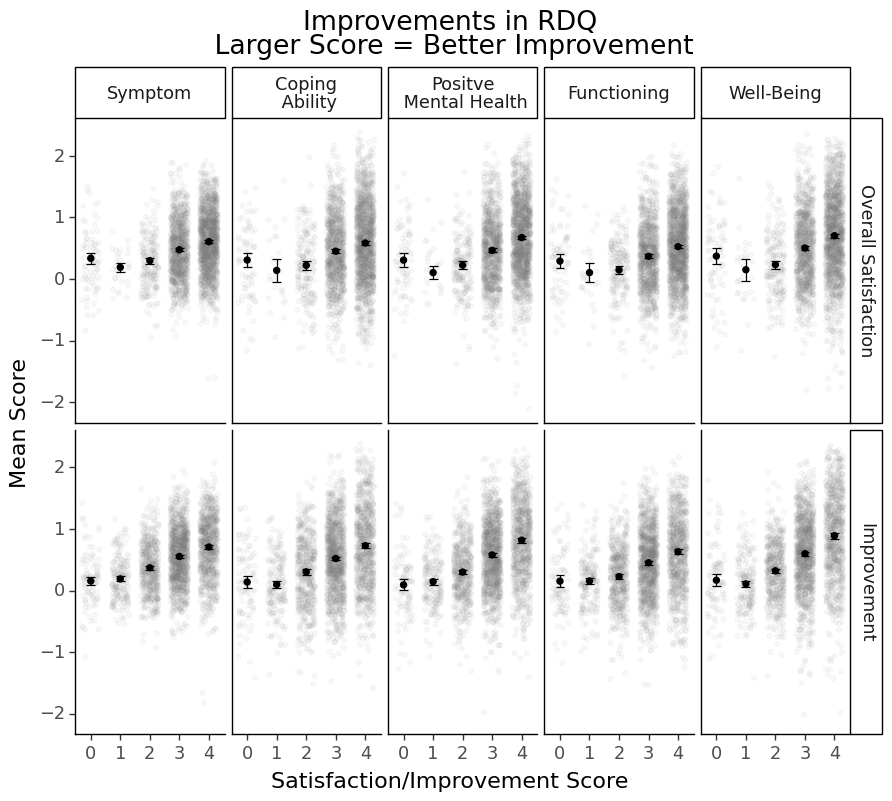

<ggplot: (8789412138921)>

In [480]:
#Change RDQ Scores and Post-treatment Patient Perceived Satisfaction & Improvement
ggplot(df_long2, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     xlab('Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Improvements in RDQ\n Larger Score = Better Improvement')

Interpretation would be qutie similar to the post-treatment RDQ score one. 

### Final Thoughts

Some may prefer conducting a linear regression model of patient satisfaction/improvent on different RDQ facets to determine which RDQ facets are significant predictors of patient satisfcation/improvement (after partialing out each others' effects). 

I would not suggest so for several reasons: 
    1. The RDQ facets were highly correlated (moderate to high correlation) -> You would partial out most of the effets
    2. All RDQ facets had clear relationships with patient satisfaction/improvement
    3. You could already tell who had stronger relationships from the correlation tables. 
    4. The relationships were not entirely linear. 
    
It is not wrong to do regression. It is just unnecessary at this point when correlation tables and visualization has already given us a rather complete picture of the story. We would have missed these points if we have had jumped in with regresion directly.  